# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [2]:
# TODO: Make all necessary imports.
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub


In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import glob

In [3]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.0.0
	• tf.keras version: 2.2.4-tf
	• Running on GPU


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [4]:
# TODO: Load the dataset with TensorFlow Datasets.
import tensorflow as tf
import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

# TODO: Create a training set, a validation set and a test set.
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/0.0.1. Subsequent calls will reuse this data.


## Explore the Dataset

In [5]:
# Check that dataset is a dictionary
print('dataset has type:', type(dataset))

# Print the keys of the dataset dictionary
print('\nThe keys of dataset are:', list(dataset.keys()))

dataset has type: <class 'dict'>

The keys of dataset are: ['test', 'train', 'validation']


In the cell below,I save the training data , test data and validation set into different variables.

In [6]:
training_set, test_set, valid_set = dataset['train'], dataset['test'], dataset['validation']

In [7]:
# TODO: Get the number of examples in each set from the dataset info.


shape_images = dataset_info.features['image'].shape
num_classes = dataset_info.features['label'].num_classes

num_training_examples  = dataset_info.splits['train'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples
num_valid_examples = dataset_info.splits['validation'].num_examples

print('\nThere are {:,} images in the test set'.format(num_test_examples))
print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_valid_examples))

# TODO: Get the number of classes in the dataset from the dataset info.

print('There are {:,} classes in our dataset'.format(num_classes))
print('The images in our dataset have shape:', shape_images)



There are 6,149 images in the test set
There are 1,020 images in the training set
There are 1,020 images in the validation set
There are 102 classes in our dataset
The images in our dataset have shape: (None, None, 3)


In [8]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(1):
    print('The images in the training set have:\n\u2022 dtype:', image.dtype, '\n\u2022 shape:', image.shape)

The images in the training set have:
• dtype: <dtype: 'uint8'> 
• shape: (500, 666, 3)


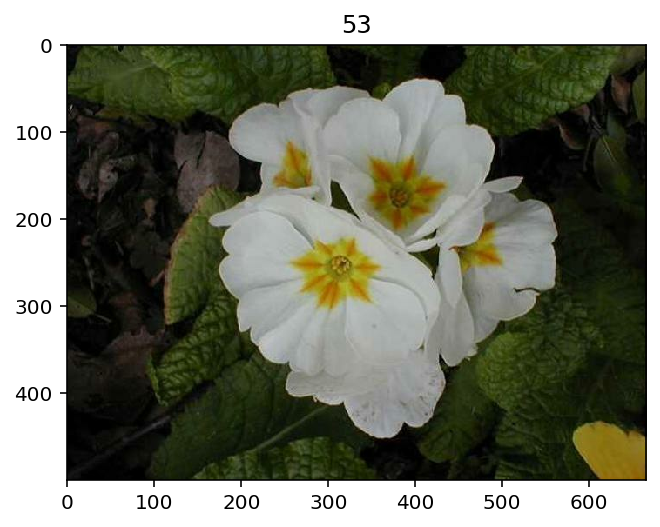

The label of this image is: 53


In [9]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 

for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.title(label+1)
plt.show()

print('The label of this image is:', label+1)

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [10]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [11]:
class_names

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [12]:
x = json_normalize(class_names)

In [13]:
x

,21,3,45,1,34,27,7,16,25,26,...,78,88,94,81,74,89,73,46,77,51
0,fire lily,canterbury bells,bolero deep blue,pink primrose,mexican aster,prince of wales feathers,moon orchid,globe-flower,grape hyacinth,corn poppy,...,lotus lotus,cyclamen,foxglove,frangipani,rose,watercress,water lily,wallflower,passion flower,petunia


In [14]:
print(x.iloc[0][53])  #53 coloumn

gaura


In [15]:
print(x.iloc[0]['53'])  #53 flower class

primula


## Notes - Please Read

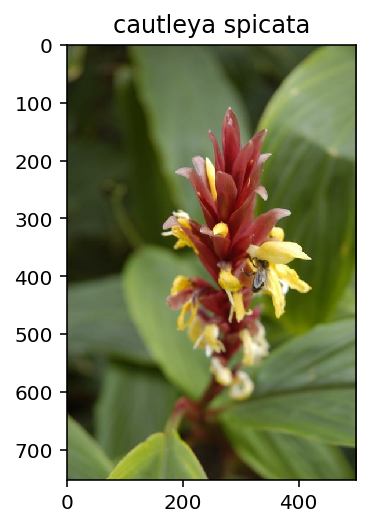

The label of this image is: 61
The class name of this image is: cautleya spicata


In [16]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in training_set.take(2):
    image = image.numpy()
    label = label.numpy()
    
h = str(label+1) #converting the numerical value back to string, due to Json data 
g = x.iloc[0][h]  #Here I select the correct label in the label list, in this case its label '61' and NOT number 61


plt.imshow(image, cmap= plt.cm.binary)
plt.title(g)
plt.show()

print('The label of this image is:', label+1)
print('The class name of this image is:', g )


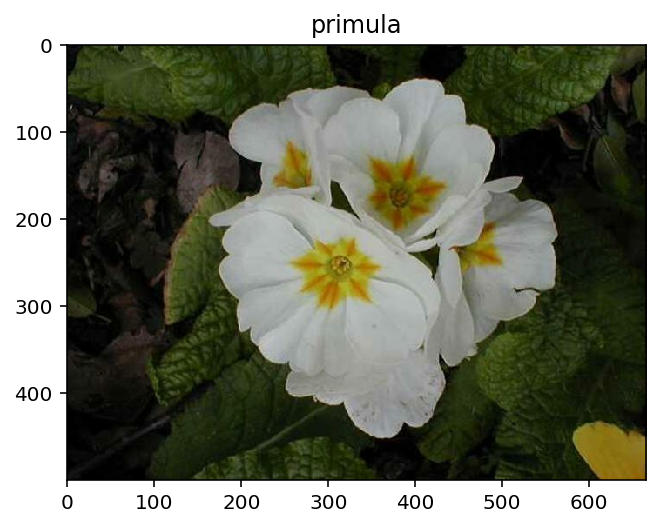

The label of this image is: 53
The class name of this image is: primula


In [17]:
for image, label in training_set.take(1):
    image = image.numpy()
    label = label.numpy()
    
h = str(label+1)
g = x.iloc[0][h]


plt.imshow(image, cmap= plt.cm.binary)
plt.title(g)
plt.show()

print('The label of this image is:', label+1)
print('The class name of this image is:', g )

I converted the label and matched the class of flower. Initially, I realised the labels DID NOT match the flower species when I started using google images to double check. 

My instinct was correct. The images had labels shortened by 1 number, (I'm guessing since the dataframe regards [0] as the first image) 

Hence I added +1 to the label.As for the label in the data frame, I spent a long time trying to find a way to order the json data, but it was simpler to convert the label into a string. As shown above, the string '53' label is not the same as the numerical number 53, when conducting a label search.

## Create Pipeline

In [32]:
# TODO: Create a pipeline for each set.
BATCH_SIZE= 32
IMG_SHAPE = 224  #Here i resize to 224 by 224


In [33]:
#I also normalize the data.
def normalize(image, label):
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))/255.0
    return image, label

train_batches = training_set.cache().shuffle(num_training_examples//4).map(normalize).batch(BATCH_SIZE).prefetch(1)

validation_batches = valid_set.cache().map(normalize).batch(BATCH_SIZE).prefetch(1)

test_batches = test_set.cache().map(normalize).batch(BATCH_SIZE).prefetch(1)



# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [34]:
# TODO: Build and train your network.


URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, 
                                   input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

#pre-trained model
feature_extractor.trainable = False

#classifier
#Here I shortened the model based on the findings later compared to
#the other trained models further down. 

#I trained a model without dropout (which is not shown here), as well as a model with dropout.
model = tf.keras.Sequential([
    feature_extractor, 
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(1024, activation='relu'),
#    tf.keras.layers.Dense(512, activation='relu'),
#    tf.keras.layers.Dense(256, activation='relu'),
#    tf.keras.layers.Dense(128, activation='relu'),
    layers.Dense(num_classes,activation='softmax')   ])


model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
#Training the model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50

network = model.fit(train_batches, 
                    epochs=EPOCHS, 
                    validation_data=validation_batches, 
                    callbacks=None)

Epoch 1/50
32/32 [==============================] - 11s 337ms/step - loss: 4.3084 - accuracy: 0.1078 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 5s 153ms/step - loss: 2.1313 - accuracy: 0.6471 - val_loss: 2.0338 - val_accuracy: 0.6451
Epoch 3/50
32/32 [==============================] - 5s 153ms/step - loss: 1.1406 - accuracy: 0.8980 - val_loss: 1.5464 - val_accuracy: 0.7245
Epoch 4/50
32/32 [==============================] - 5s 153ms/step - loss: 0.6825 - accuracy: 0.9637 - val_loss: 1.2985 - val_accuracy: 0.7745
Epoch 5/50
32/32 [==============================] - 5s 153ms/step - loss: 0.4480 - accuracy: 0.9853 - val_loss: 1.1597 - val_accuracy: 0.7873
Epoch 6/50
32/32 [==============================] - 5s 153ms/step - loss: 0.3219 - accuracy: 0.9941 - val_loss: 1.0692 - val_accuracy: 0.7980
Epoch 7/50
32/32 [==============================] - 5s 153ms/step - loss: 0.2430 - accuracy: 0.9961 - val_loss: 1.0041 - val_accuracy: 0.80

In [36]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

ACCURACY = network.history['accuracy']
VALIDATION_ACC = network.history['val_accuracy']

LOSS = network.history['loss']
VALIDATION_LOSS = network.history['val_loss']

epochs_range = range(EPOCHS)

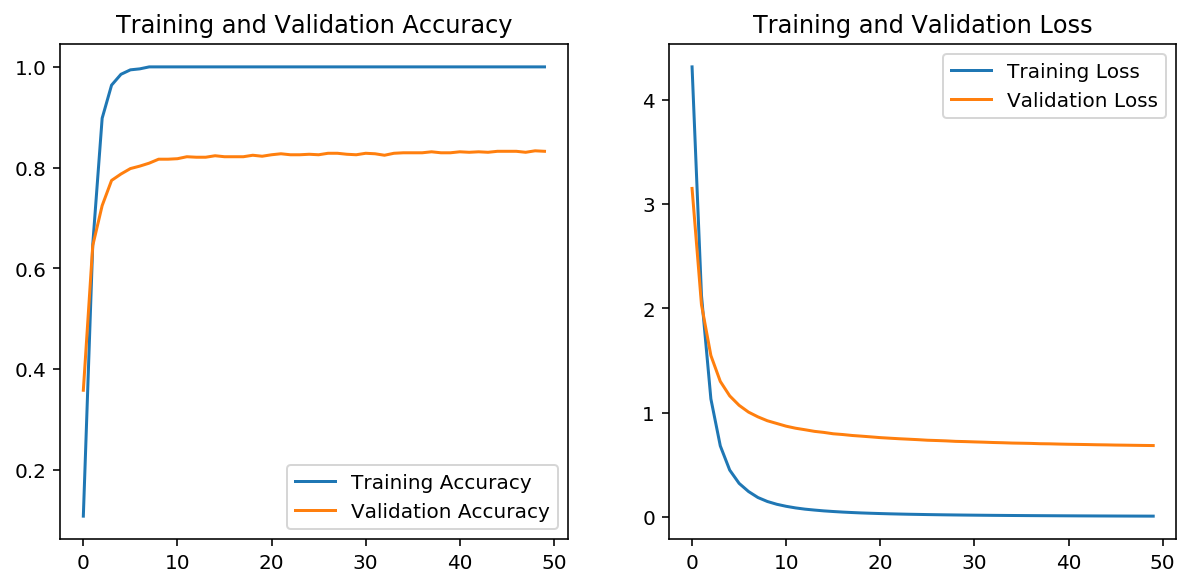

In [37]:
    plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, ACCURACY, label='Training Accuracy')
plt.plot(epochs_range, VALIDATION_ACC, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, LOSS, label='Training Loss')
plt.plot(epochs_range, VALIDATION_LOSS, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [38]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

results = model.evaluate(test_batches)
print('test loss, test acc:', results)

193/193 [==============================] - 14s 75ms/step - loss: 0.8272 - accuracy: 0.7899
test loss, test acc: [0.82717959729501, 0.7898845]


Compared the the previous submission, I tested with 25 epochs instead of 5. This model performed with around 78-79% accuracy compared with 74%.

## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [39]:
# TODO: Save your trained model as a Keras model.
t = time.time()

keras_model = "./{}.h5".format(int(t))
print(keras_model)

model.save(keras_model)

./1585112417.h5


In [40]:
!ls

1585112417.h5  label_map.json  Project_Image_Classifier_Project.ipynb
assets	       NoDropout.png   test_images


## Another model 

In [30]:


URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, 
                                   input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

#pre-trained model
feature_extractor.trainable = False

#classifier
model2 = tf.keras.Sequential([
    feature_extractor, 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(num_classes,activation='softmax')   ])


model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [31]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 10

network2 = model2.fit(train_batches, 
                    epochs=EPOCHS, 
                    validation_data=validation_batches, 
                    callbacks=None)

Epoch 1/10
32/32 [==============================] - 10s 326ms/step - loss: 4.5952 - accuracy: 0.0157 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 5s 151ms/step - loss: 3.9218 - accuracy: 0.1225 - val_loss: 3.2211 - val_accuracy: 0.2422
Epoch 3/10
32/32 [==============================] - 5s 151ms/step - loss: 2.8298 - accuracy: 0.3020 - val_loss: 2.2550 - val_accuracy: 0.4539
Epoch 4/10
32/32 [==============================] - 5s 151ms/step - loss: 1.8824 - accuracy: 0.4824 - val_loss: 1.7458 - val_accuracy: 0.5480
Epoch 5/10
32/32 [==============================] - 5s 152ms/step - loss: 1.3019 - accuracy: 0.6451 - val_loss: 1.5209 - val_accuracy: 0.6206
Epoch 6/10
32/32 [==============================] - 5s 151ms/step - loss: 0.9008 - accuracy: 0.7451 - val_loss: 1.4114 - val_accuracy: 0.6333
Epoch 7/10
32/32 [==============================] - 5s 152ms/step - loss: 0.5433 - accuracy: 0.8314 - val_loss: 1.3320 - val_accuracy: 0.66

In [32]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.

ACCURACY_2 = network2.history['accuracy']
VALIDATION_ACC_2 = network2.history['val_accuracy']

LOSS_2 = network2.history['loss']
VALIDATION_LOSS_2 = network2.history['val_loss']

epochs_range = range(EPOCHS)

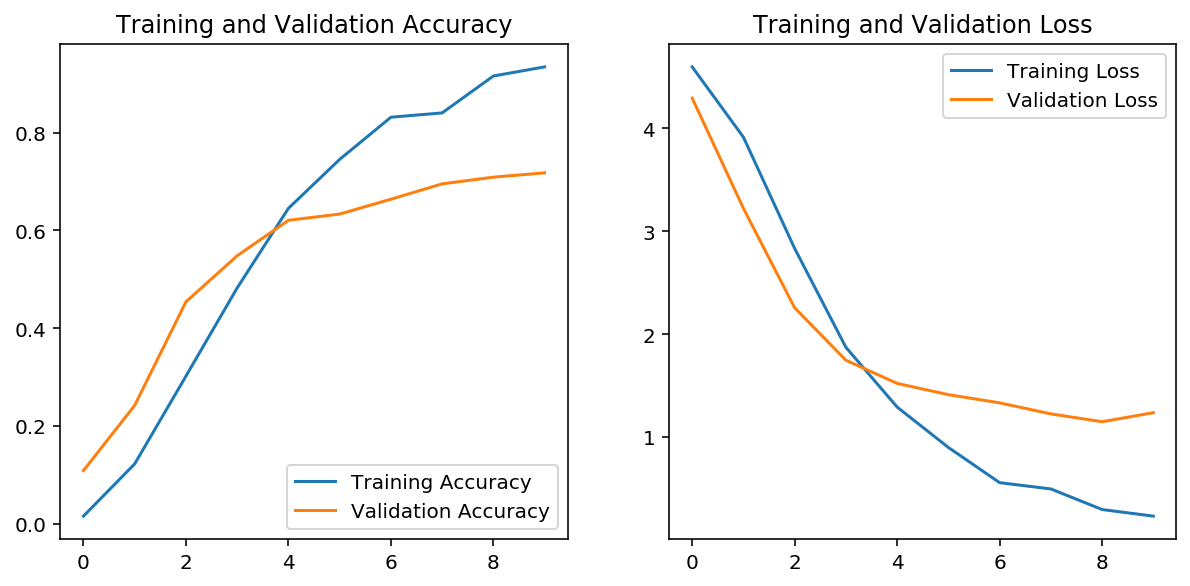

In [33]:
    plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, ACCURACY_2, label='Training Accuracy')
plt.plot(epochs_range, VALIDATION_ACC_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, LOSS_2, label='Training Loss')
plt.plot(epochs_range, VALIDATION_LOSS_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
results_2 = model2.evaluate(test_batches)
print('test loss, test acc:', results_2)

193/193 [==============================] - 14s 73ms/step - loss: 1.3822 - accuracy: 0.6839
test loss, test acc: [1.3821886333159215, 0.683851]


Test accuracy was actually slightly worse than the basic model with fewer Epochs and fewer layers. My instinct was telling me that adding more hidden layers may result in slight overfitting. I trained a previous model without the dropout layers. Here is what I found.


<img src='NoDropout.png' width=500px>

Validation accuracy was worse off without dropout! My instinct is telling me that since our dataset is still relatively small (around 8000 images), having large neural nets trained on relatively small datasets can overfit the training data. Perhaps I should use 50% dropout rather than 20%? I will need to further experiment and play around.

Reading some online articles such as Geoffrey Hinton, et al. in the 2012 paper that first introduced dropout titled 
“Improving neural networks by preventing co-adaptation of feature detectors” 

For datasets including handwritten digit recognition (MNIST), photo classification (CIFAR-10), and speech recognition (TIMIT). '50% dropout for all hidden units and 20% dropout for visible units' was the general rule.


## Load the Keras Model

Load the Keras model you saved above.

In [41]:
# TODO: Load the Keras model

load_model = tf.keras.models.load_model(keras_model, custom_objects={'KerasLayer': hub.KerasLayer})

load_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [42]:
# TODO: Create the process_image function

def process_image(img):
    image = np.squeeze(img)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))/255.0
    return image


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

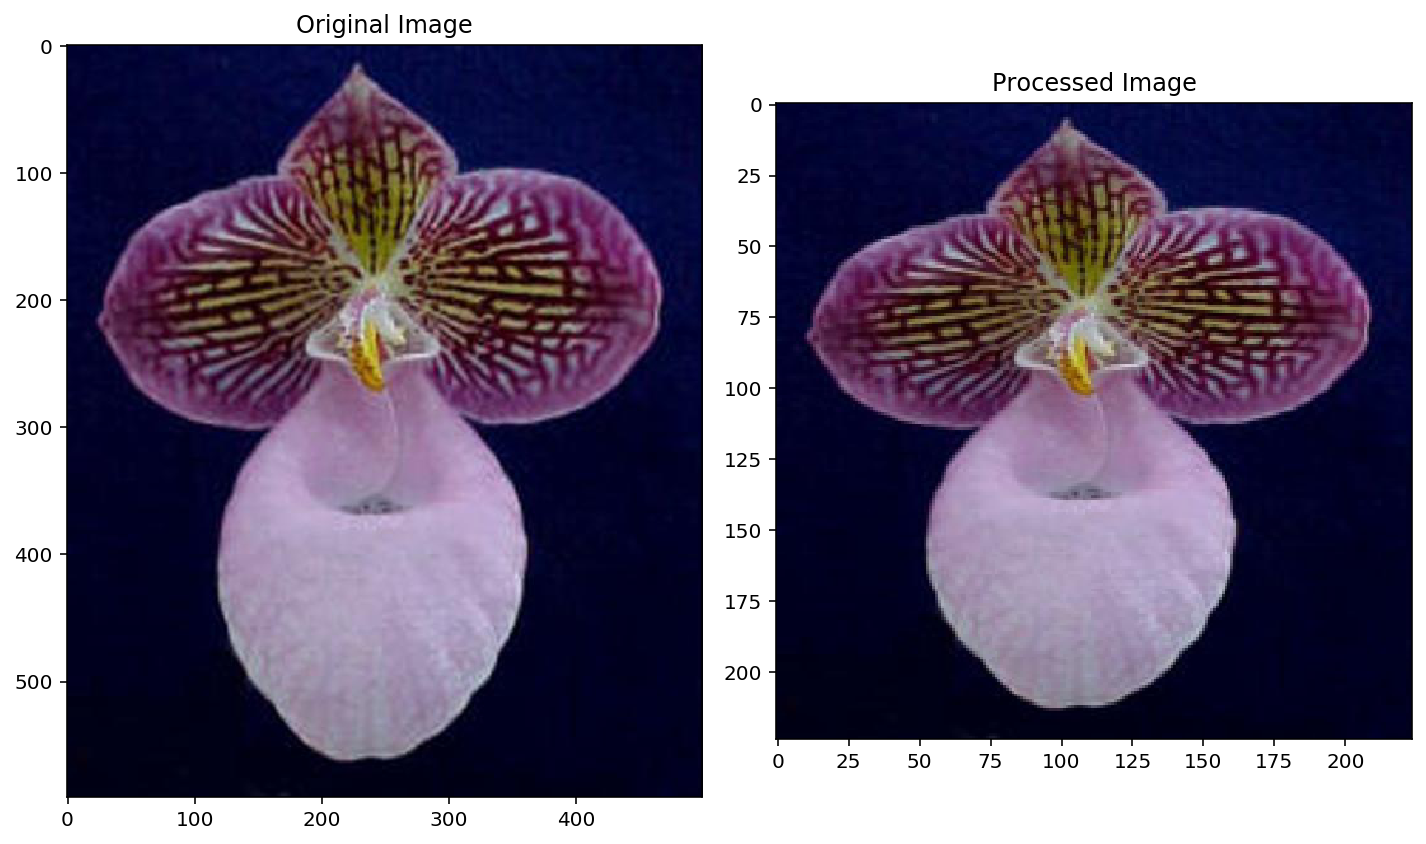

In [43]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [44]:
# TODO: Create the predict function

def predict(img_path, model, top_k):
    img = Image.open(img_path)
    test = np.asarray(img)
    processed = process_image(test)
    
    prediction = model.predict(np.expand_dims(processed, axis=0))
    
    PROBS, CLASS = tf.math.top_k(prediction, top_k)
    
    #Once again, the 'value' is added by 1, since the json reads the first value as 0.
    #This should correctly label the classes with the right flowers.
    TOP_CLASSES = [class_names[str(value+1)] for value in CLASS.cpu().numpy()[0]]
    print('Top classes', TOP_CLASSES)
    return PROBS.numpy()[0], TOP_CLASSES

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

Top classes ['orange dahlia', 'english marigold', 'blanket flower', 'osteospermum', 'barbeton daisy']


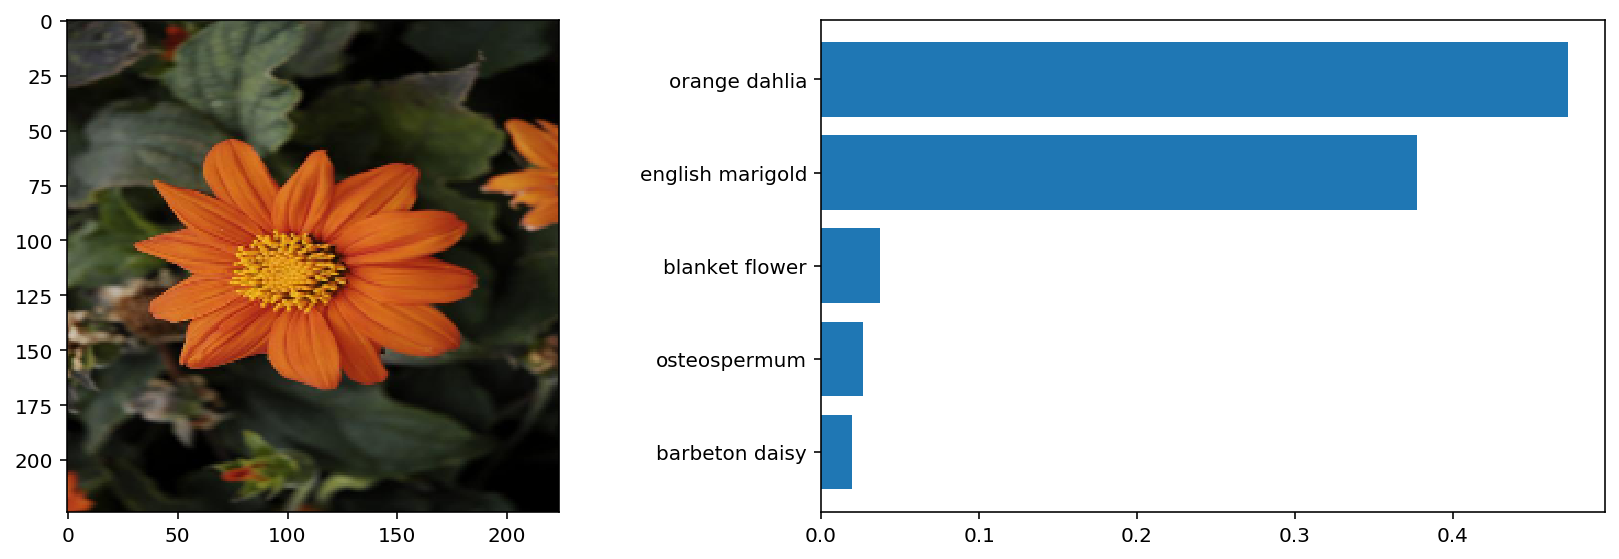

Top classes ['cautleya spicata', 'red ginger', 'wallflower', 'snapdragon', 'siam tulip']


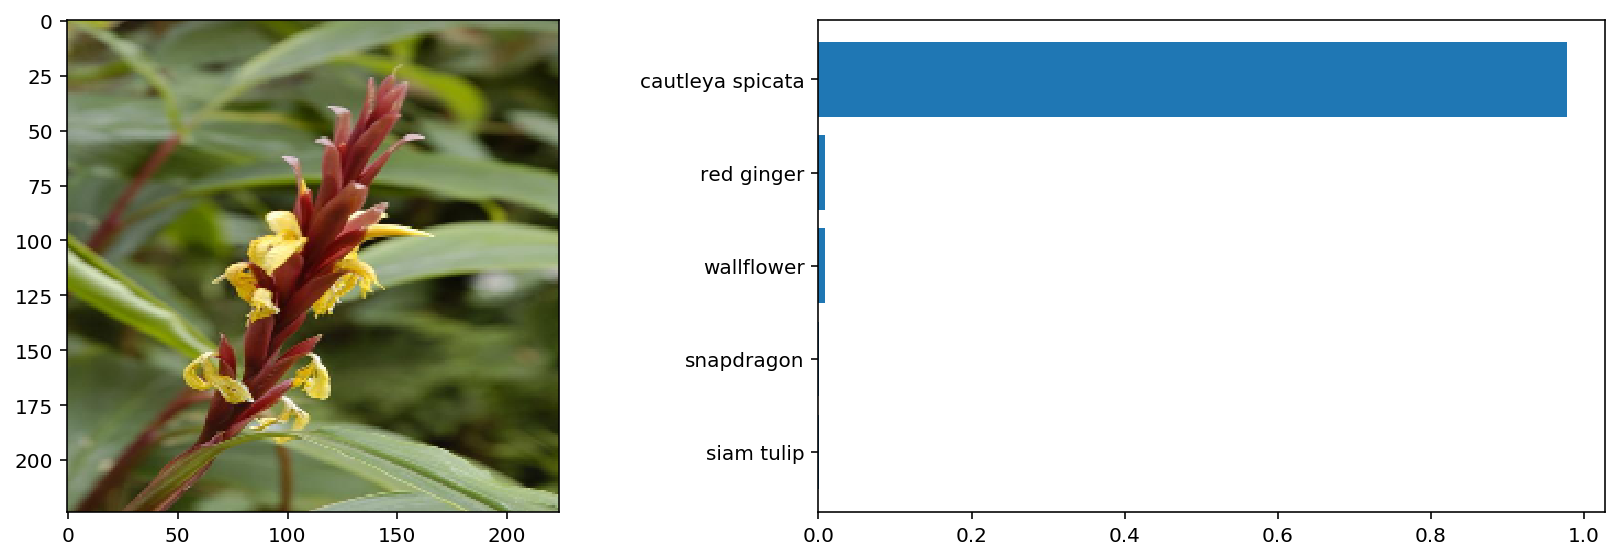

Top classes ['wild pansy', 'balloon flower', 'clematis', 'mexican aster', 'silverbush']


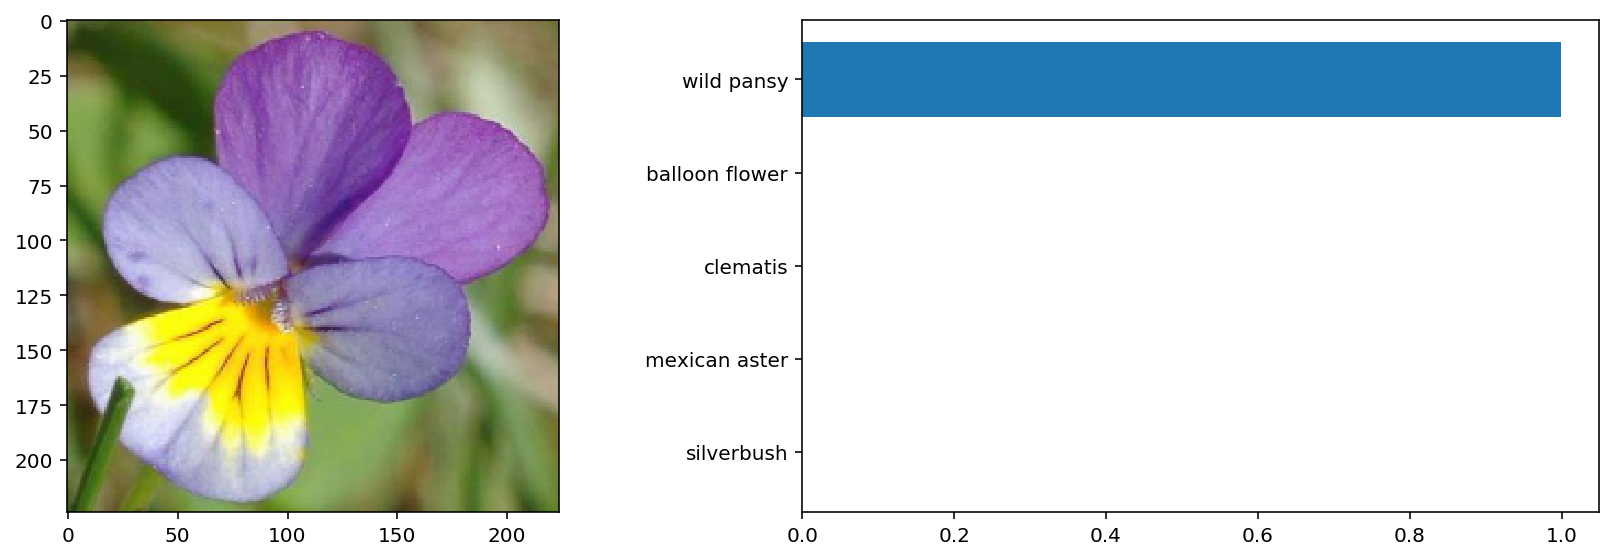

Top classes ['hard-leaved pocket orchid', 'bearded iris', 'moon orchid', 'passion flower', 'king protea']


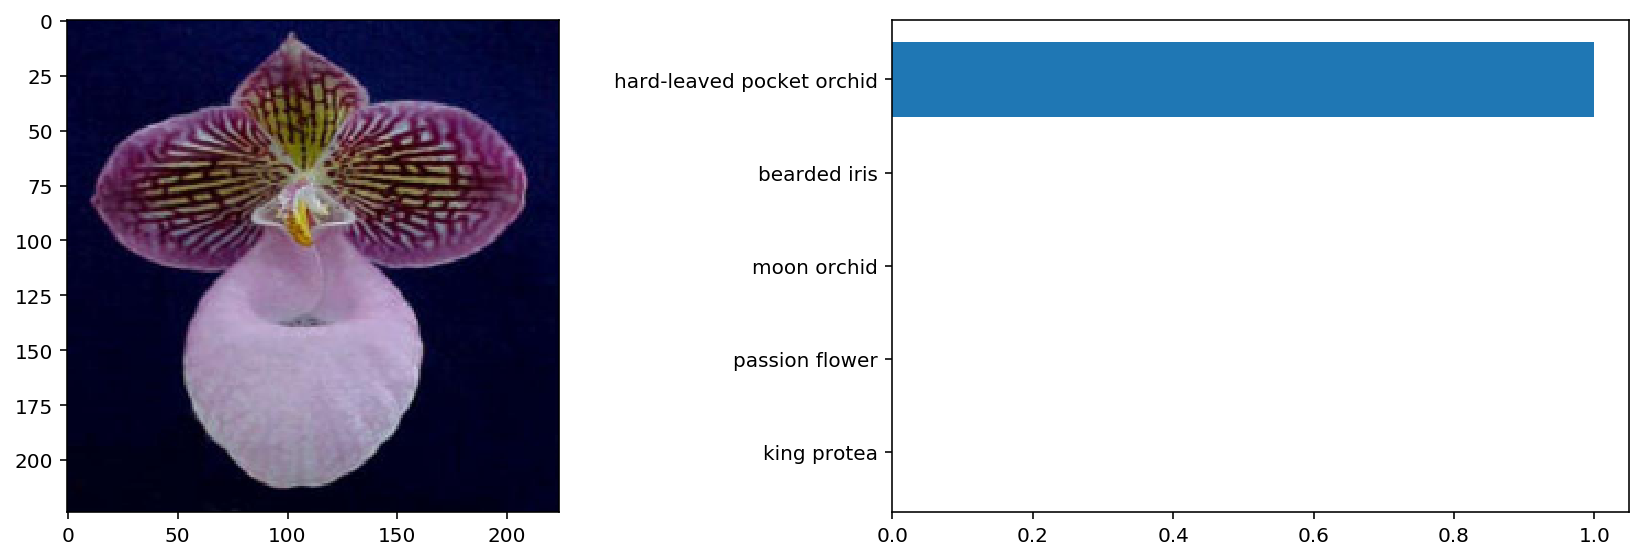

In [45]:
# TODO: Plot the input image along with the top 5 classes

files = glob.glob('./test_images/*.jpg')
for image_path in files:
    img = Image.open(image_path)
    test = np.asarray(img)
    processed = process_image(test)
    probs, classes = predict(image_path, load_model, 5)
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
    ax1.imshow(processed)
    ax2 = plt.barh(classes[::-1], probs[::-1])
    plt.tight_layout()
    plt.show()

  Doubled checked with google images, the flowers are indeed with the correct class and label.